# Delay Tolerant Networks

### Description

In several instances, network communications can occur with relevant delays, as for extra-terrestial communications or for supervised monitoring networks. In such network deciding which node can communicate with which other node and when is extremely complicated issue (a np-completed scheduling problem).

### Assignments

1. Generate a series of patterns of trasmissions on a network represented as a graph. In such graph the edges are weighted accordingly to the delay between transmittion and reception.
2. Implement euristic algorithms to lower the potential of the network, i.e. aiming at minimizing the distance of the communications from their final destination.
3. Find out the most efficient algorithm

### Contacts
Leonardo Badia <badia@dei.unipd.it>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

n = 10
c = 3e8
T_tx = 10  # da regolare
r_max = 60e9  # Marte
tau_max = 130

In [2]:
### Generates a random network of n nodes (the first one corresponds to earth)
### r = max distance

def generate_network(n,r_max,seed=100,polar = False):
    
    np.random.seed(seed)
    
    r = np.random.rand(n,1)*r_max
    r[0] = 0 #Earth
    theta = np.random.rand(n,1)*4*np.pi - 2*np.pi
    phi = np.random.rand(n,1)*4*np.pi - 2*np.pi
    
    if polar==True:
        return np.hstack((r,theta,phi))  #polar coordinates
    
    x = r * np.cos(theta) * np.sin(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)
    
    return np.hstack((x,y,z))   #cartesian coordinates

In [3]:
### Creates the weighted adjacency matrix of the network
### Entries represent propagation times between nodes

def adjacency_matrix(nodes):
    
    n1 = nodes[:, np.newaxis, :]
    n2 = nodes[np.newaxis, :, :]
    
    A = np.linalg.norm(n1-n2, axis = 2)/c
    
    return A

In [4]:
nodes = generate_network(n,r_max)
A = adjacency_matrix(nodes)
sorted_nodes = np.argsort(A[0,:])     #sorting based on distance from Earth

if(False):   #TEST
    print(nodes.shape)
    print(A.shape)
    print("sorted_nodes: {}".format(sorted_nodes))

In [5]:
def plot_network(nodes):
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(nodes[1:,0],nodes[1:,1],nodes[1:,2])
    ax.scatter(nodes[0,0],nodes[0,1],nodes[0,2],color="red",s=100)   #Earth
    plt.show()

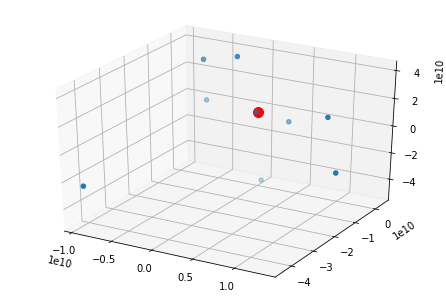

In [6]:
plot_network(nodes)

In [7]:
## disable some links for a certain amount of time
##
## modes:
## light mode: few links, short time
## heavy mode: few links, long time
## unstable mode: many links, short time
## extreme mode: many links, long time
##
## priority: random, near, far
## prioritize disabling of links involving nodes near or far from Earth
## 
## custom_n_targets = number of targets
## custom_offtimes: array containing possible values for off times expressed in number of updates of A

def disable_links(A,n_updates, mode="light",priority="random", custom_n_targets = None, custom_offtimes = None):

    At = np.repeat(A[:, :, np.newaxis], n_updates, axis=2) #add temporal dimension
    
    print("AAAAAAAAAAA")
    print(At.shape)
    print(At)
    t_nodes = np.arange(n)
    
    if priority == "random":
        np.random.shuffle(t_nodes)   #nodes targeted for link removal
    elif priority == "near":
        t_nodes = sorted_nodes[:int(np.ceil(n/3))]
    elif priority == "far":
        t_nodes = np.flip(sorted_nodes)[:int(np.ceil(n/3))]
    
    possible_links = []
    possible_links = np.array([[x,y] for x in t_nodes for y in range(n) if x!=y if A[x,y]<tau_max if [y,x] not in possible_links])

    if mode == "light":  
        n_targets = possible_links.shape[0]//3
        offtimes = [n_updates//10]   # selected links stay off for around 1/10 of the total time
            
    elif mode == "heavy":
        n_targets = possible_links.shape[0]//3
        offtimes = [n_updates//3]
        
    elif mode == "unstable":
        n_targets = possible_links.shape[0]*3//4
        offtimes = [n_updates//10]
        
    elif mode == "extreme":
        n_targets = possible_links.shape[0]*3//4
        offtimes = [n_updates//3]
    
    else:   #use light mode if a wrong 
        print("Wrong value for \"mode\", light mode will be used")
        n_targets = possible_links.shape[0]//3
        offtimes = [n_updates//10]
    
    if custom_n_targets != None: n_targets = custom_n
    if custom_offtimes != None: offtimes = custom_offtimes
 
    disabled_links = np.random.permutation(possible_links)[:n_targets,:]
    
    for link in disabled_links:
        print(link)
        start = np.random.randint(0,n_updates)
        print("start {}".format(start))
        end = start + np.random.choice(offtimes)
        print("end {}".format(end))
        for t in range(start,min(n_updates,end)):
            At[link[0],link[1],t] = At[link[1],link[0],t] = np.inf
            
    return At

In [8]:
### TEST DISABLE LINKS
### SORTED NODES = [0 4 5 8 1 2 9 3 6 7]

if(False):   #TEST
    At = disable_links(A,100,mode="light")

    for i in range(20):
        B = np.copy(At[:,:,i*5])
        B[B>tau_max] = 0
        plt.spy(B)
        plt.show()